In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=0.3
B=1.31
C=-2.4

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [4]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

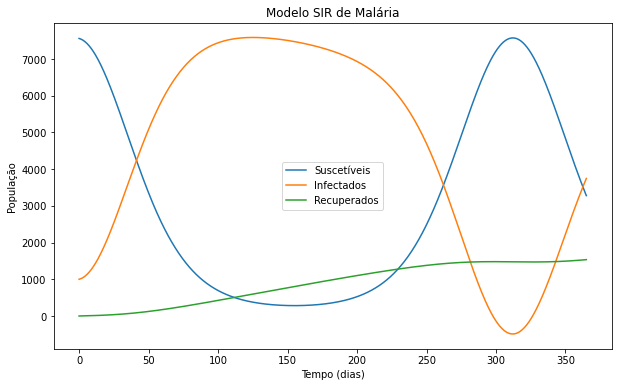

In [5]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [6]:
min(I_H)

-489.73519446438144

In [7]:
max(S_H)

7572.536827762521

In [8]:
S_H[0]

7558.0

In [9]:
gamma

1/1095

In [10]:
n(gamma)

0.000913242009132420

In [11]:
n(1/1000)

0.00100000000000000

In [12]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, 1/1000, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

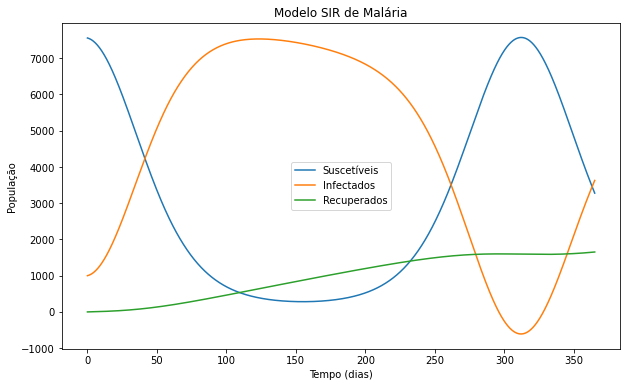

In [13]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [14]:
min(I_H)

-608.5657827102632

Aumentar o $\gamma$ fará cvom que o número mínimo de infectados diminua ainda mais

In [15]:
365*3

1095

In [16]:
365*5

1825

In [17]:
365*4

1460

In [18]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, 1/1825, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

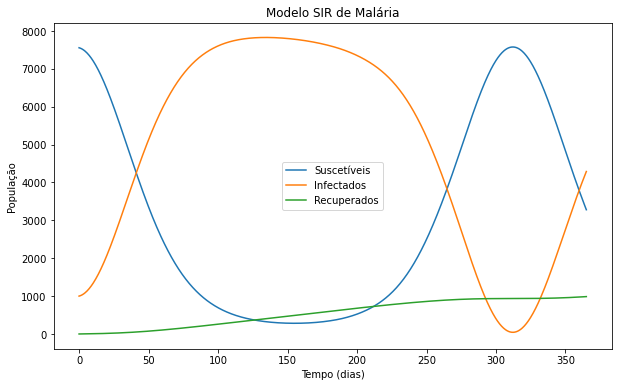

In [19]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

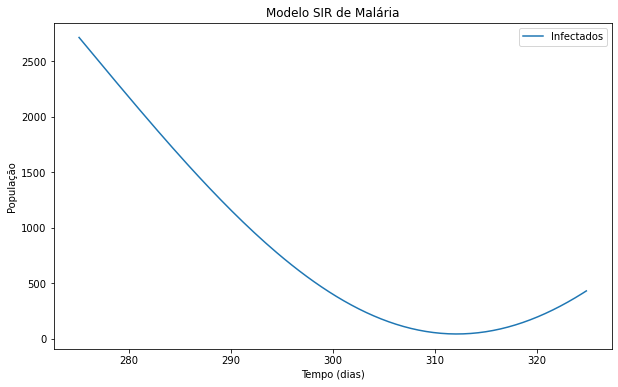

In [20]:
times = sol.t
tempo_inicial = 275
tempo_final = 325

# Encontrando os índices correspondentes ao intervalo desejado
indice_tempo_inicial = np.argmax(times >= tempo_inicial)
indice_tempo_final = np.argmax(times >= tempo_final)

S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
#plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times[indice_tempo_inicial:indice_tempo_final], I_H[indice_tempo_inicial:indice_tempo_final], label='Infectados')
#plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

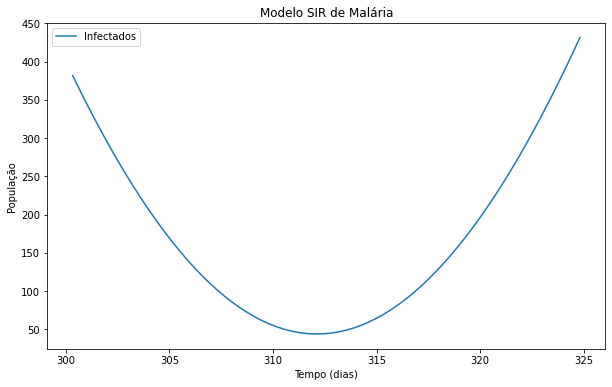

In [21]:
times = sol.t
tempo_inicial = 300
tempo_final = 325

# Encontrando os índices correspondentes ao intervalo desejado
indice_tempo_inicial = np.argmax(times >= tempo_inicial)
indice_tempo_final = np.argmax(times >= tempo_final)

S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
#plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times[indice_tempo_inicial:indice_tempo_final], I_H[indice_tempo_inicial:indice_tempo_final], label='Infectados')
#plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [22]:
sol.t

array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
        17.53753754,  17.9029029 ,  18.26826827,  18.63363363,
        18.998999  ,  19.36436436,  19.72972973,  20.0950951 ,
        20.46046046,  20.82582583,  21.19119119,  21.55655656,
        21.92192192,  22.28728729,  22.65265265,  23.01

In [23]:
min(I_H)

43.90901790497173

In [24]:
I_H[0]

1000.0

In [25]:
times[855]

312.3873873873874

In [26]:
# Função para minimizar - I_H no tempo t
def minimize_I_H(t):
    index = np.argmin(np.abs(times - t))
    return I_H[index]

resultado_minimizacao = minimize_scalar(minimize_I_H, bounds=(tempo_inicial, tempo_final), method='bounded')
t_minimiza_I_H = resultado_minimizacao.x

In [27]:
print(f"O valor de t que minimiza I_H é: {t_minimiza_I_H:.2f}")

O valor de t que minimiza I_H é: 312.23


In [28]:
indice_tempo_minimiza = np.argmin(np.abs(sol.t - t_minimiza_I_H))

# Obtendo o tempo correspondente ao resultado da minimização
tempo_minimiza = sol.t[indice_tempo_minimiza]

print(f"O tempo correspondente ao resultado da minimização é: {tempo_minimiza:.2f}")

O tempo correspondente ao resultado da minimização é: 312.39


Supondo a duração média da infecciosidade como sendo de 5 anos (1825 dias), foi possível garantir que o número de infectados não ficará negativo.

In [29]:
min(I_H)

43.90901790497173